In [2]:
import joblib
import seaborn as sb
import minisom
import pandas as pd
from IPython.display import display, HTML
from collections import Counter
import adotto_som
import pickle
from matplotlib import cm
import pyranges

ModuleNotFoundError: No module named 'adotto_som'

In [511]:
raw = joblib.load("adotto_TRregions_v1.1_3mers.jl")
feats, gcs = raw

In [512]:
som = minisom.MiniSom(25, 25, 64, sigma=1.5, learning_rate=1,
                      topology='hexagonal',
                      neighborhood_function='gaussian', 
                      activation_distance='euclidean'
                     )
som.train_batch(feats, 1_000_000, verbose=True)
with open('som_TR_3mers_25x25_experimental.pkl', 'wb') as outfile:
    pickle.dump(som, outfile)

 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.10526401480211288


In [513]:
winners = [som.winner(_) for _ in feats]
counts = np.zeros(som.distance_map().shape)
gc_pct = np.zeros(som.distance_map().shape)
for i, g in zip(winners, gcs):
    counts[i] += 1
    gc_pct[i] += g
gc_pct /= counts

In [583]:
all_regions = pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed.gz", sep='\t', header=None)
all_regions.columns = ["chr", "start", "end", "ovl_flag", "up_buff", "dn_buff", "hom_span", "n_filtered",
"n_annos", "n_subregions", "mu_purity", "pct_annotated", "interspersed", "patho", "codis", "gene_flag",
"biotype", "annos"]
all_regions['Neuron'] = winners

In [464]:
patho = all_regions[all_regions['patho'] != '.'].copy()
patho['marker'] = 'patho'
codis = all_regions[all_regions['codis'] != '.'].copy()
codis['marker'] = 'codis'
inter = all_regions[all_regions['interspersed'] != '.'].sample(100).copy()
inter['marker'] = 'inter'

In [467]:
combined = pd.concat([patho, codis, inter], axis=0)

In [478]:
m_regions = combined[['chr', 'start', 'end']].to_numpy().tolist()
reference = "/Users/english/code/references/grch38/GRCh38_1kg_mainchrs.fa"
combined_feats, combined_gcs = adotto_som.regions_to_kmers(m_regions, reference, k=3, ordered=True)

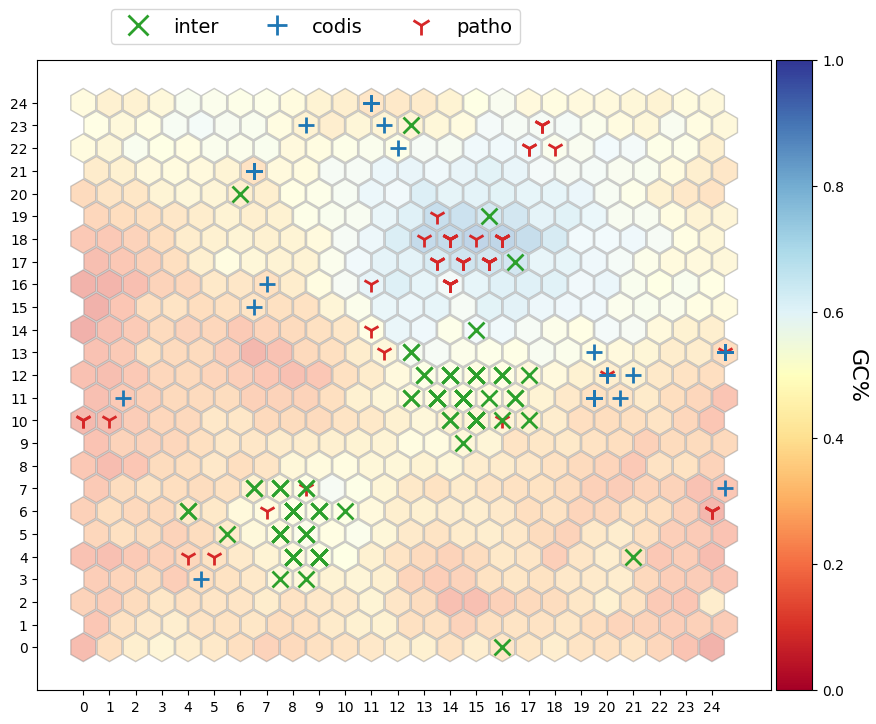

In [570]:
comb_winners = adotto_som.plot_hex(som, 
                       combined_feats, 
                       combined['marker'].to_numpy().tolist(),
                       marker_map={'inter':'x', 'codis':'+', 'patho':'1'},
                       default_colors=['C2', 'C0', 'C3'],
                       umatrix=gc_pct,
                       umatrix_label="GC%",
                       color_map=cm.RdYlBu)
combined['Neuron'] = comb_winners

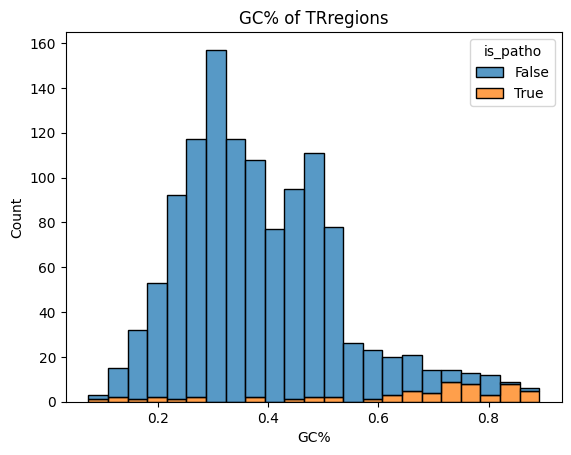

In [597]:
g = pd.Series(gcs).sample(1000).to_frame()
g.columns = ['gc']
g['is_patho'] = False
combined['gc'] = combined_gcs
combined['is_patho'] = combined['patho'] != '.'
g = pd.concat([g[['gc', 'is_patho']], combined[['gc','is_patho']]])
g['is_patho'].value_counts()
p = sb.histplot(data=g, x='gc', hue='is_patho', multiple='stack')
hide = p.set(title="GC% of TRregions", xlabel="GC%")

In [515]:
patho = pd.read_csv("/Users/english/code/adotto/pathogenic/Patho.tsv", sep='\t')
patho['motif'] = np.where(patho['Motifs 2'].apply(lambda x: isinstance(x, str)),
                          patho["Motifs 2"], patho["Motifs 1"])

In [516]:
motif_map = dict(zip(patho['Locus'], patho['motif']))

In [517]:
view = combined[combined['marker'] == 'patho'].copy()
view["motif"] = view['patho'].map(motif_map)
with pd.option_context('display.max_rows', None):
    show = view.sort_values(['Neuron'])[["patho", "Neuron", 'motif']]
    display(show)

,patho,Neuron,motif
1623943,SAMD12,"(0, 10)","TGAAA,TAAAA"
601202,BEAN1,"(0, 10)","TGGAA,TAAAA"
40136,DAB1,"(1, 10)","AAAAT,GAAAT,AAAAT"
1669487,FXN,"(4, 4)","A,GAA"
1147870,RFC1,"(5, 4)","AAAAG,AAAGG,AAGGG,AAGAG,AGAGG,AACGG,GGGAC,AAAGGG"
824630,STARD7,"(7, 6)","TGAAA,TAAAA"
1079302,CNBP,"(8, 7)","CAGG,CAGA,CA"
738813,COMP,"(11, 13)",GTC
574979,XYLT1,"(11, 14)",GCC
917518,PRNP,"(11, 16)",GGTGGTGGCTGGGGGCAGCCTCAT


In [574]:
cluster_A_n = [(13, 18), (14, 18), (15, 18), (16, 18), (13, 19), (13, 17), (14, 17), (15, 17), (14, 16)]
cluster_B_n = [(17,23), (17, 22), (18,22)]
cluster_C_n = [(0, 10), (1, 10)]
cluster_D_n = [(4,4), (5,4)]
cluster_E_n = [(24, 6)]

In [576]:
cluster_A = view['Neuron'].map(lambda x: x in cluster_A_n)
cluster_B = view['Neuron'].map(lambda x: x in cluster_B_n)
cluster_C = view['Neuron'].map(lambda x: x in cluster_C_n)
cluster_D = view['Neuron'].map(lambda x: x in cluster_D_n)
cluster_E = view['Neuron'].map(lambda x: x in cluster_E_n)

cluster_A.sum(), cluster_B.sum(), cluster_C.sum(), cluster_D.sum(), cluster_E.sum()

(40, 6, 3, 2, 3)

In [578]:
def smallest_roll(seq):
    if isinstance(seq, float):
        return "GCN" # HOXA13 and ARX cheat
    if ',' in seq:
        return seq
    sm = sorted(list(seq))
    i = seq.index(sm[0])
    return seq[i:] + seq[:i]

for name, i in [('A', cluster_A), ('B', cluster_B), ('C', cluster_C), ('D', cluster_D), ('E', cluster_E)]:
    x = view[i]['motif'].apply(smallest_roll).value_counts()
    display(x)
    print('-' * 10)

CGG                     10
CCG                      8
CNG                      7
CTG                      6
GCN                      2
CTA,CTG                  1
ACCTCGCTGTGCCGCTGCCG     1
GGCCTG,CGCCTG            1
CGCGGGGCGGGG             1
GCA,GCC                  1
CAG,CCG                  1
CCCCGG                   1
Name: motif, dtype: int64

----------


AGC    6
Name: motif, dtype: int64

----------


AAAAT,GAAAT,AAAAT    1
TGGAA,TAAAA          1
TGAAA,TAAAA          1
Name: motif, dtype: int64

----------


AAAAG,AAAGG,AAGGG,AAGAG,AGAGG,AACGG,GGGAC,AAAGGG    1
A,GAA                                               1
Name: motif, dtype: int64

----------


TTTTA,TTTCA,TTTTA    2
TTTTA,TTTCA          1
Name: motif, dtype: int64

----------


In [581]:
len(view[cluster_A | cluster_B | cluster_C | cluster_D | cluster_E]), len(view)

(54, 62)

# Heatmaps

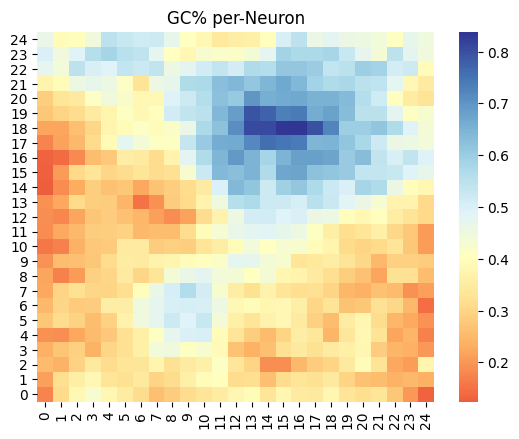

In [523]:
p = sb.heatmap(np.flip(gc_pct.T, axis=0),
              cmap=cm.RdYlBu, center=gc_pct.mean())
hide = p.set(yticklabels=range(25)[::-1], title="GC% per-Neuron", )

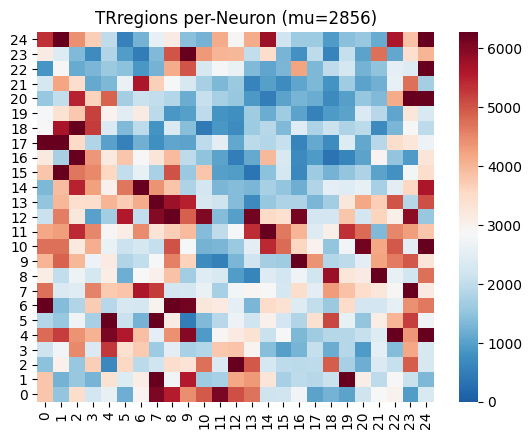

In [745]:
mu = counts.mean()
sd = counts.std()
p = sb.heatmap(np.flip(counts.T, axis=0),
              center=counts.mean(), vmax=mu + (sd*2), vmin=max(0, mu - (sd*2)), cmap=cm.RdBu_r)
hide = p.set(yticklabels=range(25)[::-1], title="TRregions per-Neuron (mu=%.0f)" % (counts.mean()))

In [ ]:
# For our assembly intersection,
# Lets check what percent of the regions per-neuron we've captured.
# Actually, we'll look at 1-pct so we can say, "we're excluding" N%.

In [604]:
# make a key of the all_regions that's chr:start-end
# load the subsets of neurons
dipcall = pd.read_csv("/Users/english/code/adotto/regions/adotto_hprc/temp/dipcall_subset.bed", sep='\t', names=["chr", "start", "end"])
adotto = pd.read_csv("/Users/english/code/adotto/regions/adotto_hprc/temp/adotto_subset.bed", sep='\t', names=["chr", "start", "end"])
both = pd.read_csv("/Users/english/code/adotto/regions/adotto_hprc/temp/both_subset.bed", sep='\t', names=["chr", "start", "end"])

In [606]:
def to_key(d):
    d['key'] = d.apply((lambda x: f"{x['chr']}:{x['start']}-{x['end']}"), axis=1)
to_key(dipcall)
to_key(adotto)
to_key(both)
        

In [608]:
to_key(all_regions)

In [609]:
all_regions['is_dipcall'] = all_regions['key'].isin(dipcall['key'])
all_regions['is_adotto'] = all_regions['key'].isin(adotto['key'])
all_regions['is_both'] = all_regions['key'].isin(both['key'])

In [612]:
dipcall_cnts = np.zeros(som.distance_map().shape)
adotto_cnts = np.zeros(som.distance_map().shape)
both_cnts = np.zeros(som.distance_map().shape)
for i in all_regions[all_regions['is_dipcall']]['Neuron']:
    dipcall_cnts[i] += 1
for i in all_regions[all_regions['is_adotto']]['Neuron']:
    adotto_cnts[i] += 1
for i in all_regions[all_regions['is_both']]['Neuron']:
    both_cnts[i] += 1

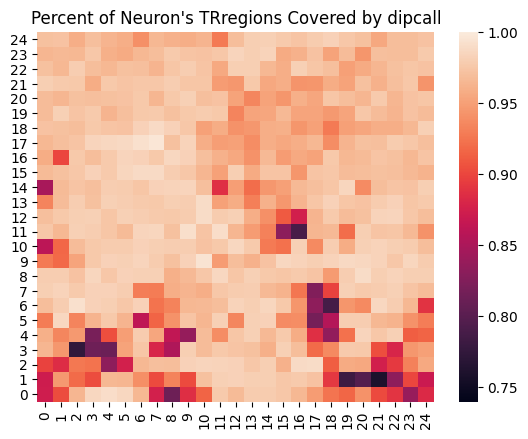

In [650]:
p = sb.heatmap(np.flip((dipcall_cnts / counts).T, axis=0), vmin=0.74, vmax=1)
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions Covered by dipcall")

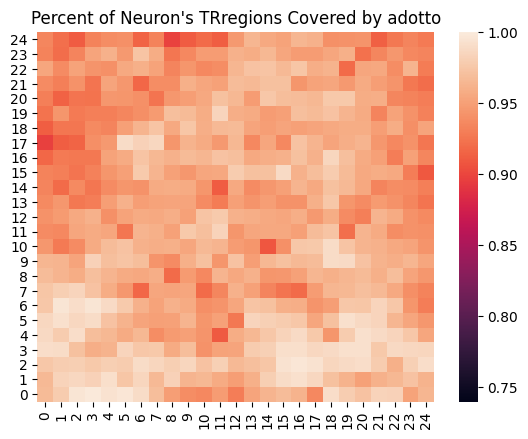

In [651]:
p = sb.heatmap(np.flip((adotto_cnts / counts).T, axis=0), vmin=0.74, vmax=1)
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions Covered by adotto")

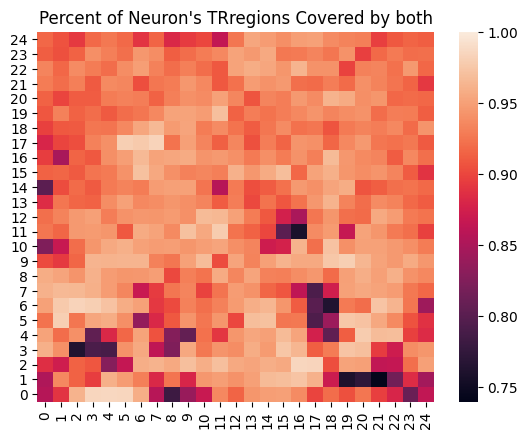

In [652]:
p = sb.heatmap(np.flip((both_cnts / counts).T, axis=0), vmin=0.74, vmax=1)
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions Covered by both")

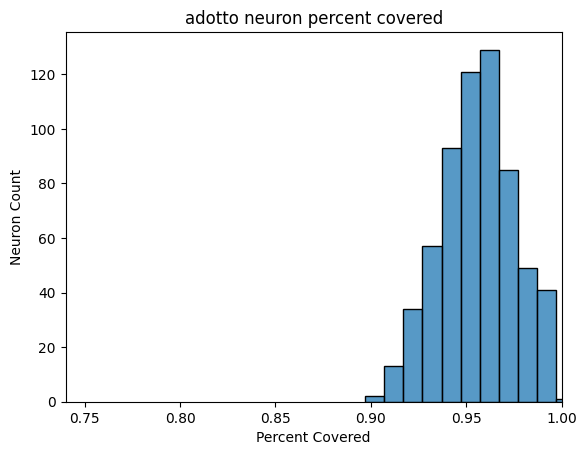

In [633]:
p = sb.histplot(data=np.ravel(adotto_cnts / counts), binwidth=0.01)
hide = p.set(xlim=(0.74, 1), title="adotto neuron percent covered", xlabel="Percent Covered", ylabel="Neuron Count")

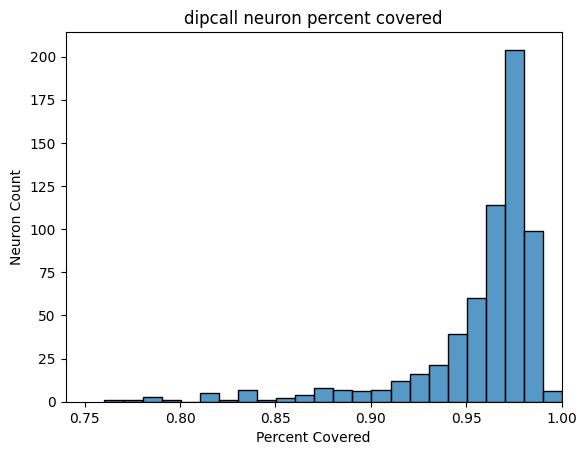

In [639]:
p = sb.histplot(data=np.ravel(dipcall_cnts / counts), binwidth=0.01)
hide = p.set(xlim=(0.74, 1), title="dipcall neuron percent covered", xlabel="Percent Covered", ylabel="Neuron Count")

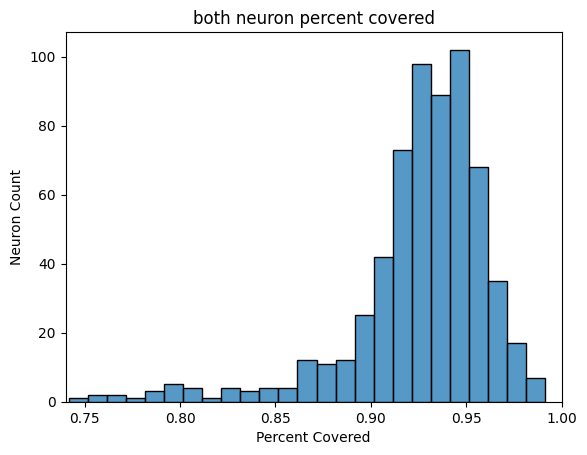

In [640]:
p = sb.histplot(data=np.ravel(both_cnts / counts), binwidth=0.01)
hide = p.set(xlim=(0.74, 1), title="both neuron percent covered", xlabel="Percent Covered", ylabel="Neuron Count")

I need to pull out the regions that hit neurons where dipcall has less than 90% covered.

Then I want to send them to JZook and ask if these regions hit somewhere more frequently.

Here's where I can use that R package for overlap intersection.
Maybe these regions just happen to more frequently hit gaps so the counts are weird...? maybe..
Let's check microsatellites.

In [658]:
micro = pd.read_csv("/Users/english/Downloads/grch38.microsatellite (1).bed", 
                    sep='\t', names=["Chromosome", "Start", "End", 'unk'])


In [659]:
m_regions = all_regions[['chr', 'start', 'end', 'Neuron']].copy()
m_regions.columns = ["Chromosome", "Start", "End", "Neuron"]
m_regions = pyranges.PyRanges(m_regions)
micro = pyranges.PyRanges(micro)

In [707]:
micro_regions = m_regions.overlap(micro)

In [708]:
len(micro_regions)

40225

In [709]:
micro_cnts = np.zeros(som.distance_map().shape)
for i in micro_regions.df['Neuron']:
    micro_cnts[i] += 1

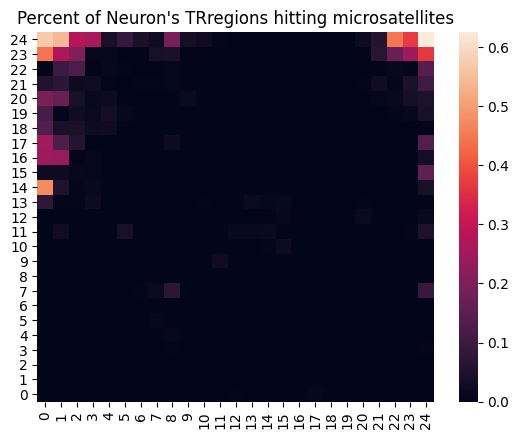

In [710]:
p = sb.heatmap(np.flip((micro_cnts / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions hitting microsatellites")

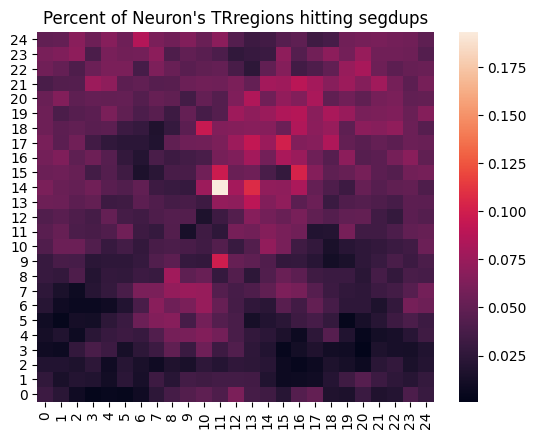

In [712]:
segdups = pd.read_csv("/Users/english/Downloads/grch38.segdup.bed", 
                    sep='\t', names=["Chromosome", "Start", "End", 'unk1', 'unk2', 'unk3'])
segdups = pyranges.PyRanges(segdups)
seg_regions = m_regions.overlap(segdups)
seg_cnts = np.zeros(som.distance_map().shape)
for i in seg_regions.df['Neuron']:
    seg_cnts[i] += 1
p = sb.heatmap(np.flip((seg_cnts / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions hitting segdups")

In [715]:
len(micro_regions), len(seg_regions), len(gap_regions)

(40225, 73736, 1333)

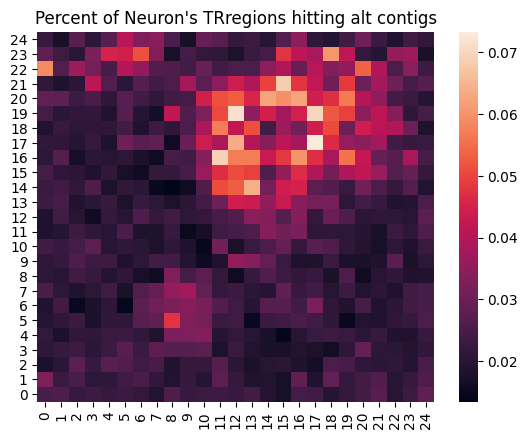

In [716]:
alts = pd.read_csv("/Users/english/Downloads/grch38.alts.bed", 
                    sep='\t', names=["Chromosome", "Start", "End"])
alts = pyranges.PyRanges(alts)
alts_regions = m_regions.overlap(alts)
alts_cnts = np.zeros(som.distance_map().shape)
for i in alts_regions.df['Neuron']:
    alts_cnts[i] += 1
p = sb.heatmap(np.flip((alts_cnts / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions hitting alt contigs")

In [747]:
all_regions[all_regions['is_both']].to_csv('TRr_v1.1_HPRC_HG002_covered.bed', sep='\t', index=False)

In [748]:
all_regions['hom_span'] = ((all_regions['hom_span'] / (all_regions['end'] - all_regions['start'])) * 100).astype(int)

In [749]:
all_regions[['chr', 'start', 'end', 'ovl_flag', 'up_buff', 'dn_buff', 'hom_span',
       'n_filtered', 'n_annos', 'n_subregions', 'mu_purity', 'pct_annotated',
       'interspersed', 'patho', 'codis', 'gene_flag', 'biotype', 'Neuron', 'annos']].to_csv("TRr_v1.1_updatedhompct_and_neuron.bed", sep='\t', index=False)

In [750]:
all_regions[['chr', 'start', 'end', 'ovl_flag', 'up_buff', 'dn_buff', 'hom_span',
       'n_filtered', 'n_annos', 'n_subregions', 'mu_purity', 'pct_annotated',
       'interspersed', 'patho', 'codis', 'gene_flag', 'biotype', 'annos']].to_csv("TRr_v1.1_updatedhompct.bed", sep='\t', index=False)

In [737]:
dip_dry = (dipcall_cnts / counts) < 0.80
x = np.array(np.unravel_index(np.argsort(dip_dry, axis=None), dip_dry.shape)).T
pos = 0
idx = []
while pos < len(x):
    i = x[pos] 
    if dip_dry[i[0], i[1]]:
        idx.append(tuple(i))
    pos += 1

In [734]:
suspicious = all_regions[all_regions['Neuron'].isin(idx)]
suspicious.to_csv("/Users/english/temp/dip_dry_regions.bed", sep='\t', index=False)
len(suspicious)

22787

In [ ]:
len(

[Text(0.5, 1.0, 'Density of HomPct of TRr by dipcall dry')]

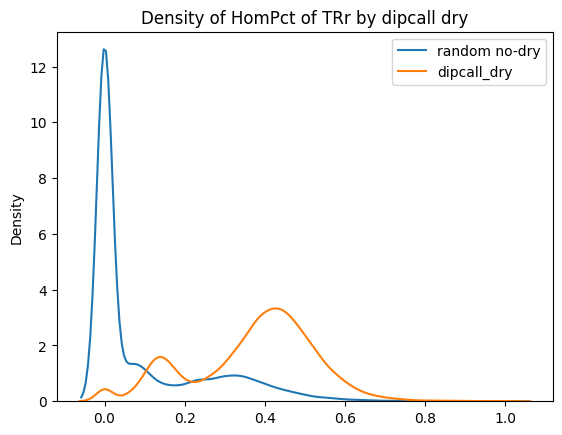

In [744]:
x = all_regions[~all_regions['Neuron'].isin(idx)].sample(30000)
rand_hom_pct = x['hom_span'] / (x['end'] - x['start'])
sb.kdeplot(rand_hom_pct, label="random no-dry")
hom_pct = suspicious['hom_span'] / (suspicious['end'] - suspicious['start'])
p = sb.kdeplot(hom_pct, label="dipcall_dry")
plt.legend()
p.set(title="Density of HomPct of TRr by dipcall dry")

In [3]:
d = pd.read_csv("TRr_v1.1_updatedhompct_and_neuron.bed", sep='\t')

[Text(0.5, 1.0, 'Regions per-Neuron'),
 Text(0, 0.5, 'Neuron Count'),
 Text(0.5, 0, 'Number of Regions')]

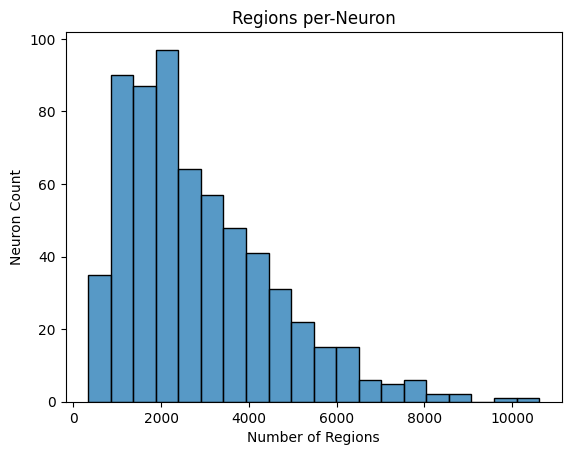

In [9]:
x = d['Neuron'].value_counts().reset_index().sort_values(['index'])
p = sb.histplot(data=x, x='Neuron')
p.set(title="Regions per-Neuron", ylabel="Neuron Count", xlabel="Number of Regions")

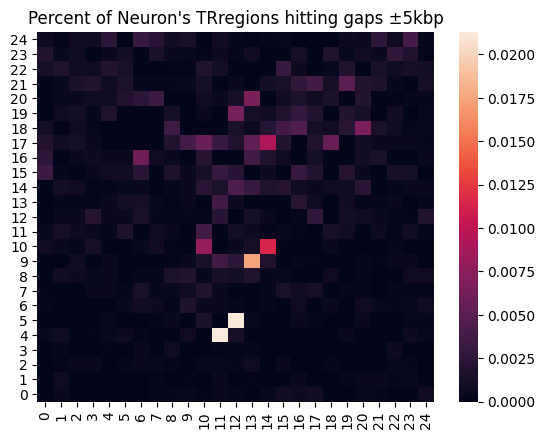

In [713]:
gaps = pd.read_csv("/Users/english/Downloads/grch38.gaps.bed", 
                    sep='\t', names=["Chromosome", "Start", "End"])
gaps['Start'] -= 5000
gaps['End'] += 5000
gaps = pyranges.PyRanges(gaps)
gap_regions = m_regions.overlap(gaps)
gap_cnts = np.zeros(som.distance_map().shape)
for i in gap_regions.df['Neuron']:
    gap_cnts[i] += 1
p = sb.heatmap(np.flip((gap_cnts / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions hitting gaps ±5kbp")

In [81]:
strawman = pd.read_csv("/Users/english/code/adotto/intersection/StrawMan1.regions.bed.gz", sep='\t', header=None)
strawman = strawman.iloc[:, :3]
strawman.columns = ["chrom", "start", "end"]
strawman_features = adotto_som.regions_to_kmers(strawman.to_numpy().tolist(), reference, ordered=True)

In [342]:
# Get how many strawmen per-neuron
strawman['Neuron'] = [som.winner(_) for _ in strawman_features]
x = strawman["Neuron"].value_counts().to_frame().reset_index()
x.columns = ["Neuron", "Count"]
m_umatrix = np.zeros(som.distance_map().shape)
for row, i in x.iterrows():
    m_umatrix[i["Neuron"]] += i['Count']


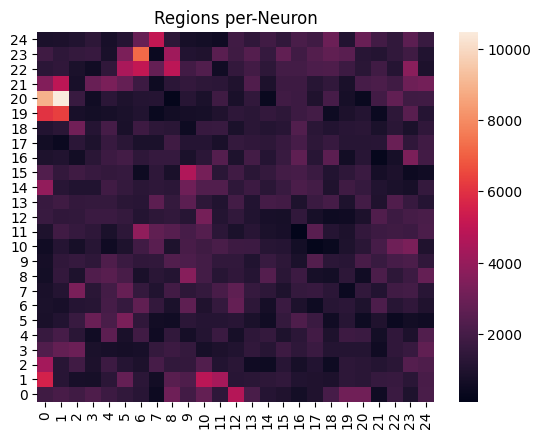

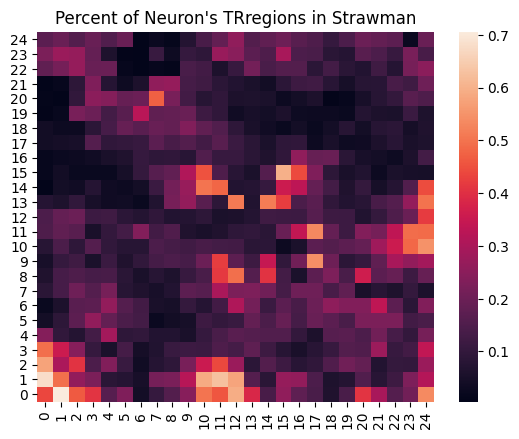

In [377]:
#p = sb.heatmap(np.flip(m_umatrix / counts, axis=0))
p = sb.heatmap(np.flip((m_umatrix / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions in Strawman")
pct_in_strawman = np.flip((m_umatrix / counts).T)

In [346]:
# Here's a question: do the regions with ANY >= 5bp variant have a pattern?
with_var = pd.read_csv("/Users/english/code/adotto/intersection/regions_v1.0_withvarcount.bed.gz", sep='\t', header=None)
with_var.columns = ["chr", "start", "end", "ovl_flag", "up_buff", "dn_buff", "hom_span", "n_filtered",
"n_annos", "n_subregions", "mu_purity", "pct_annotated", "interspersed", "patho", "codis", "gene_flag",
"biotype", "annos", "vars_lt5", "vars_ge5"
]

In [362]:
has_var = with_var[with_var["vars_ge5"] != 0].copy()
has_var_features = adotto_som.regions_to_kmers(has_var[["chr", "start", "end"]].to_numpy().tolist(), 
                                                reference, ordered=True)[0]


In [364]:
# Get how many strawmen per-neuron
has_var['Neuron'] = [som.winner(_) for _ in has_var_features]
x = has_var["Neuron"].value_counts().to_frame().reset_index()
x.columns = ["Neuron", "Count"]
has_var_umatrix = np.zeros(som.distance_map().shape)
for row, i in x.iterrows():
    has_var_umatrix[i["Neuron"]] += i['Count']


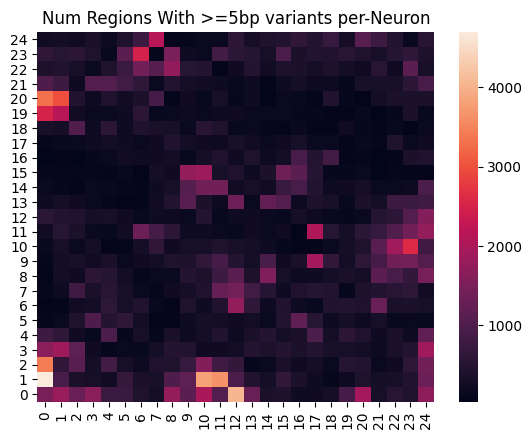

In [379]:
p = sb.heatmap(np.flip(has_var_umatrix.T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Num Regions With >=5bp variants per-Neuron")

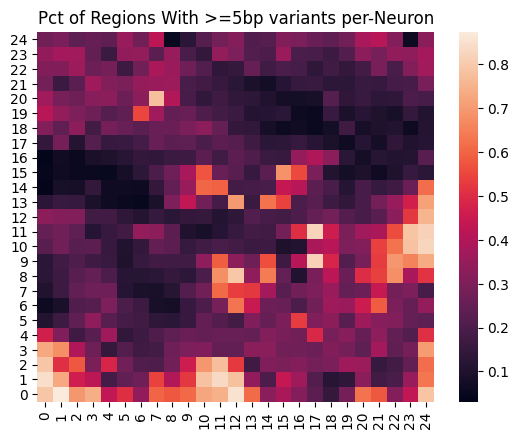

In [380]:
p = sb.heatmap(np.flip((has_var_umatrix / counts).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Pct of Regions With >=5bp variants per-Neuron")
pct_regions_with_var = np.flip((has_var_umatrix / counts).T, axis=0)

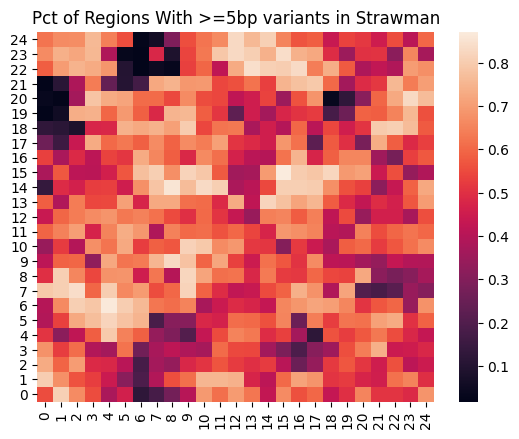

In [385]:
p = sb.heatmap(np.flip((m_umatrix / has_var_umatrix).T, axis=0))
hide = p.set(yticklabels=range(25)[::-1], title="Pct of Regions With >=5bp variants in Strawman")

In [414]:
j = np.ravel(np.flip((m_umatrix / has_var_umatrix).T, axis=0))
from sklearn.svm import OneClassSVM
x = OneClassSVM(nu=0.05, kernel='linear')

In [415]:
is_out_o = x.fit_predict(j.reshape(-1,1))

In [441]:
is_out = is_out_o.reshape(m_umatrix.shape) != 1

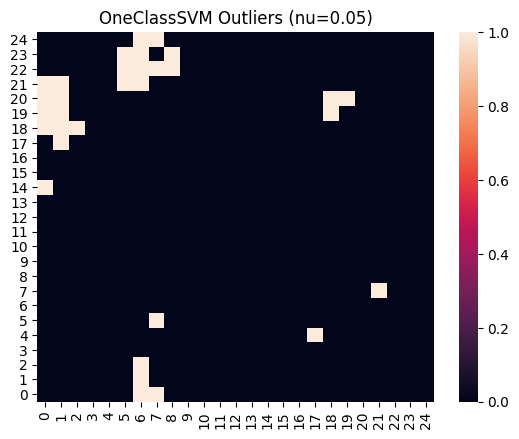

In [442]:
p = sb.heatmap(is_out)
hide = p.set(yticklabels=range(25)[::-1], title="OneClassSVM Outliers (nu=0.05)")

In [455]:
f = pd.concat([pd.Series(j, name="Percent"), pd.Series(is_out_o != 1, name="outlier").astype(str)], axis=1)

[Text(0.5, 1.0, 'Per-Neuron Strawman Over w/Variants'),
 Text(0, 0.5, 'Neuron Count')]

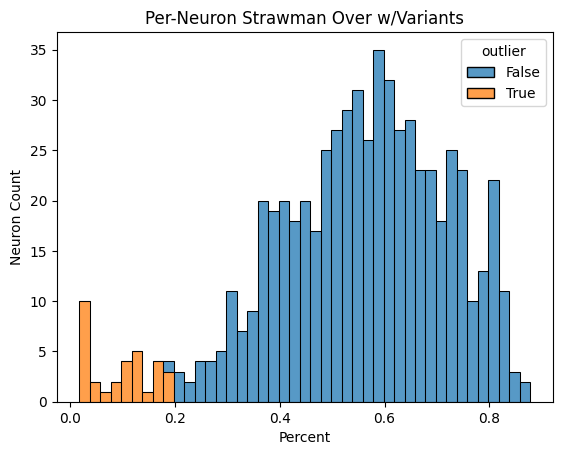

In [459]:
p = sb.histplot(data=f, x="Percent", hue="outlier", binwidth=0.02, multiple='stack')
p.set(title="Per-Neuron Strawman Over w/Variants", ylabel="Neuron Count")

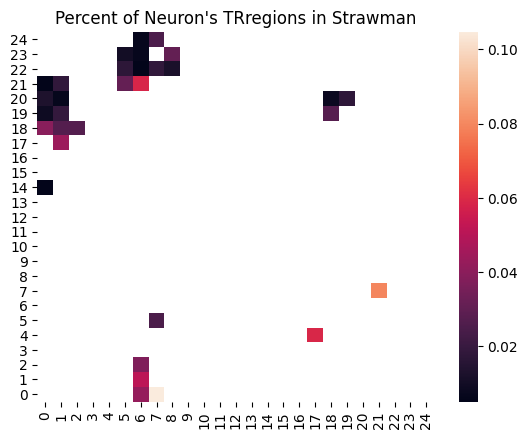

In [452]:
#p = sb.heatmap(np.flip(m_umatrix / counts, axis=0))
x = np.flip((m_umatrix / counts).T, axis=0)
x = np.where(is_out, x, np.nan)
p = sb.heatmap(x)
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's TRregions in Strawman")

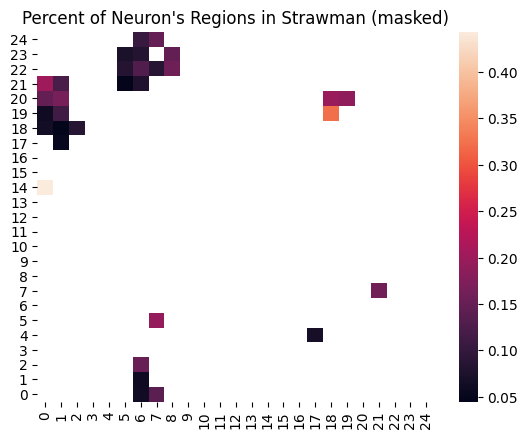

In [438]:
masked = np.where(is_out, np.flip((m_umatrix / counts)).T, np.nan)
p = sb.heatmap(masked)
hide = p.set(yticklabels=range(25)[::-1], title="Percent of Neuron's Regions in Strawman (masked)")